## scPRAM

scPRAM (single-cell Perturbation-Response Analysis Model) is a computational framework designed to analyze single-cell perturbation data. It enables the prediction of cell-specific gene expression changes in response to perturbations, using a deep learning model trained on pre-perturbation profiles.

**Reference**: [scPRAM GitHub Repository](https://github.com/jiang-q19/scPRAM)

In [1]:

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
from scpram import models
from scpram import evaluate

### Step 2: Data Requirements

Input Requirements for scPRAM

Before applying scPRAM, input data should be preprocessed as follows:

    Quality filtering: Although not explicitly handled by scPRAM, it is recommended to remove low-quality cells and genes using standard Scanpy functions (e.g., sc.pp.filter_cells, sc.pp.filter_genes).

    Normalization: Data should be normalized. The authors recommend using sc.pp.normalize_total followed by sc.pp.log1p, as seen in the official examples.

    Do scale or Do not scale: Like some machine learning models, scPRAM require scaling of the data (i.e., sc.pp.scale). The model expects log-normalized data, and z-scored data.

These preprocessing steps are critical for accurate model inference.

In [ ]:

adata = sc.read("/PATH/to/mon_anndata_scale.h5ad")
# Check if the "raw" layer exists in adata.layers
if "raw" in adata.layers:
    adata.X = adata.layers["raw"].copy()
    print("adata.X has been set to adata.layers['raw']")
else:
    print("No 'raw' layer found in adata.layers. adata.X remains unchanged.")

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10, zero_center=False) #comment this line to see wath appen if we don't scale 




adata.X has been set to adata.layers['raw']


Visualisation of dataset

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


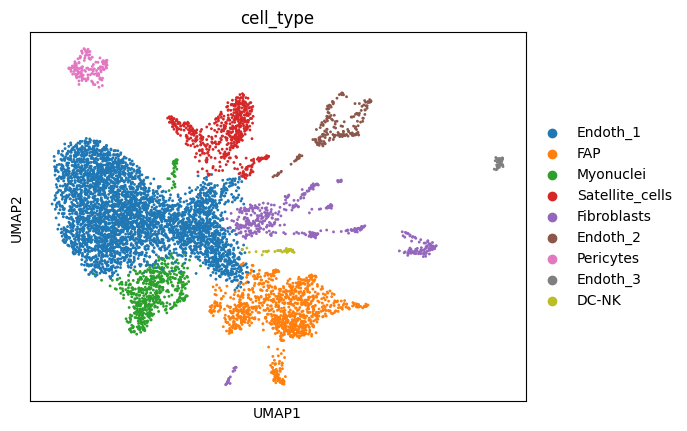

In [3]:
sc.pl.umap(adata, color = "cell_type")

### Step 3: Model Setup

This section initializes the scPRAM model and prepares it for training. The model leverages a shared encoder-decoder neural network to capture the latent representation of gene expression changes induced by perturbations.

Key components of the model include:

    - A perturbation encoder

    - A latent space representing cell states

    - A decoder that reconstructs gene expression under perturbations

In [4]:
model = models.SCPRAM(input_dim=adata.n_vars, device='cuda')
model = model.to(model.device)

Set the data specific keys

In [5]:
# Dictionary of key names as expected by scPRAM (adjust based on your dataset)
key_dic = {'condition_key': 'genotype',
           'cell_type_key': 'cell_type',
           'ctrl_key': 'WT',
           'stim_key': 'DMD',
           'pred_key': 'predict',
           }

### Step 4: Model Training, Cell Prediction, and Evaluation

In this step, the model is:

    1) Trained on a subset of the data using defined loss functions.
    
    Parameters related to the input dataset, such as:

        Number of perturbations

        Number of genes

        Batch sizes for training and testing

        Data splits for training and validation
    
    Model parameters :
        
        learning rate, numbers of epochs

    => These parameters influence both model performance and convergence 

    2) Models were used to predict the expression profile of cells under perturbations.

    3) Evaluated using metrics like:

        R-squared between predicted differentially expressed genes and actual observed differentially expressed genes after perturbation 
            - R squared for the mean and variance of expressions
        
        Visualisation of predicted cells in PCA and UMAP spaces
        
        Visualisation of differentially expressed genes with common representation (violinplots and bubble plots) 

A high R² indicates strong predictive power of the model.

In [6]:
# List of unique cell types in the dataset
cell_types = adata.obs[key_dic['cell_type_key']].unique()


=== Processing cell type: Endoth_1 ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s, SCPRAM_loss=5.4e+3, kl_loss=780, recon_loss=1.08e+4] 
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


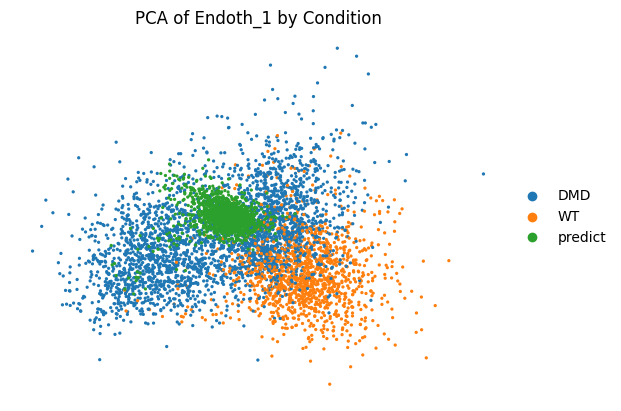

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


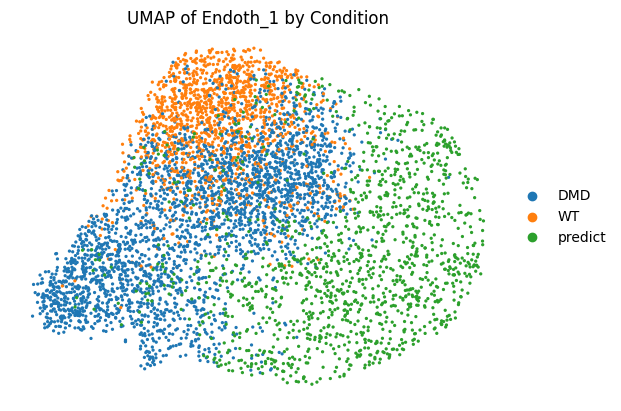

common DEGs:  0


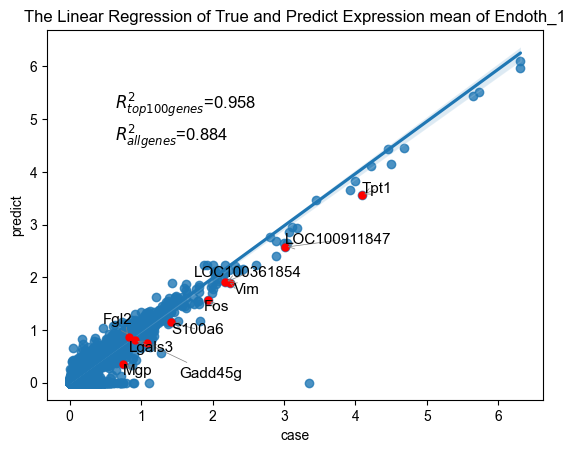

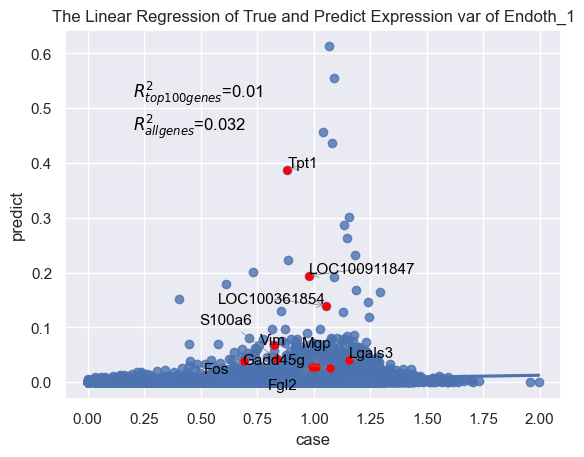

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


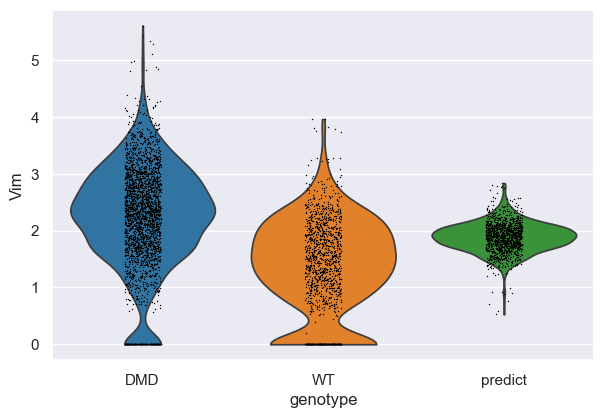

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


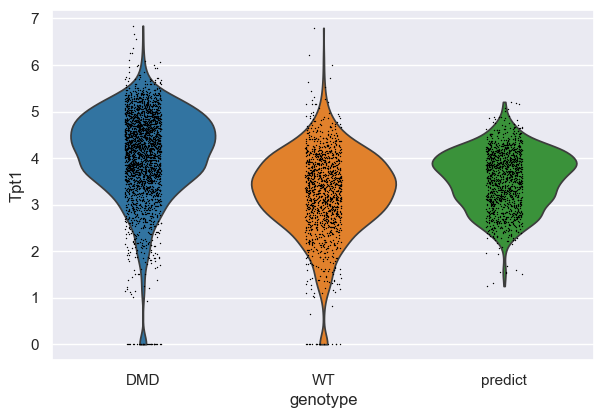

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


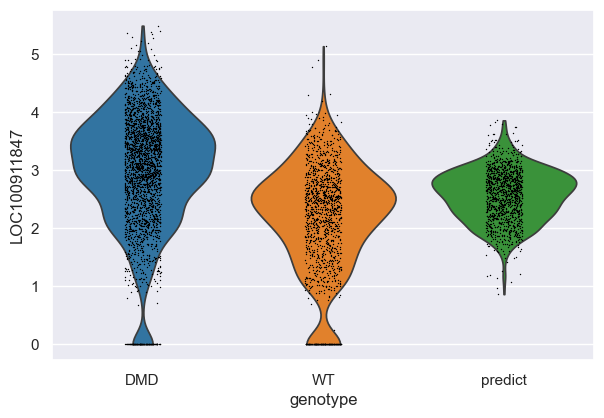

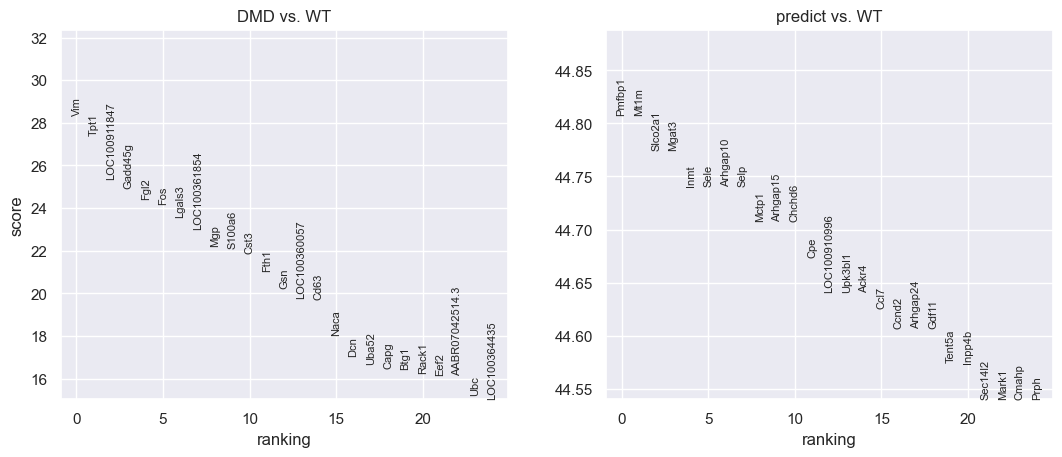

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


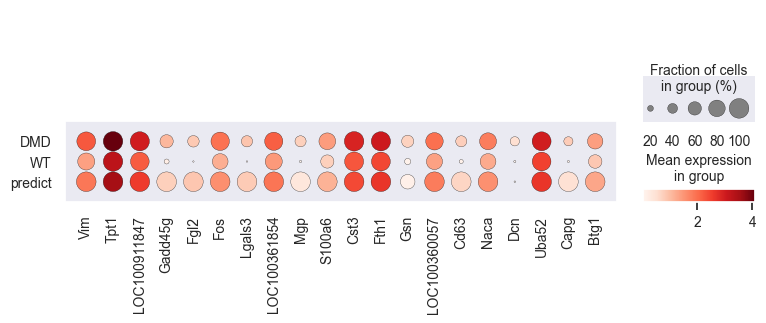


=== Processing cell type: Fibroblasts ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s, SCPRAM_loss=5.37e+3, kl_loss=852, recon_loss=1.07e+4]
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabrina/a

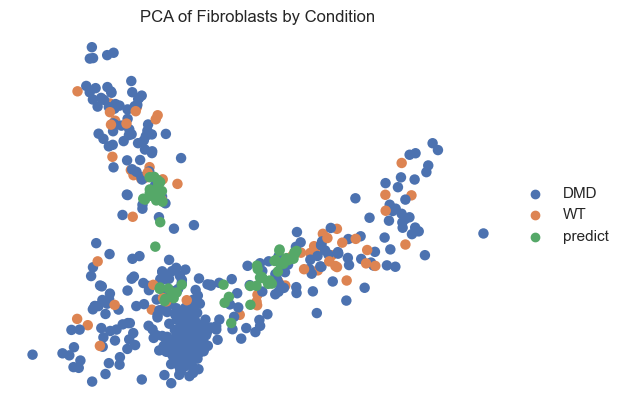

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


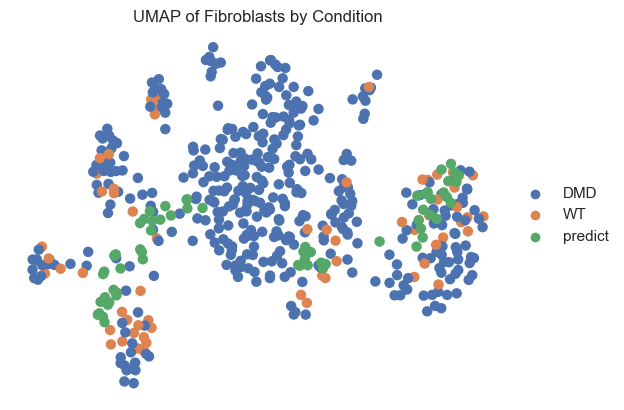

common DEGs:  2


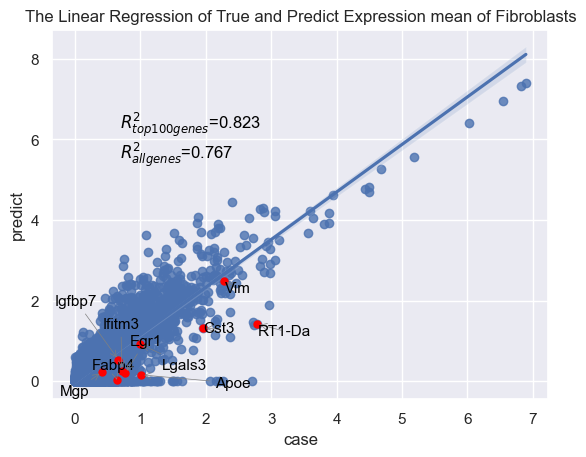

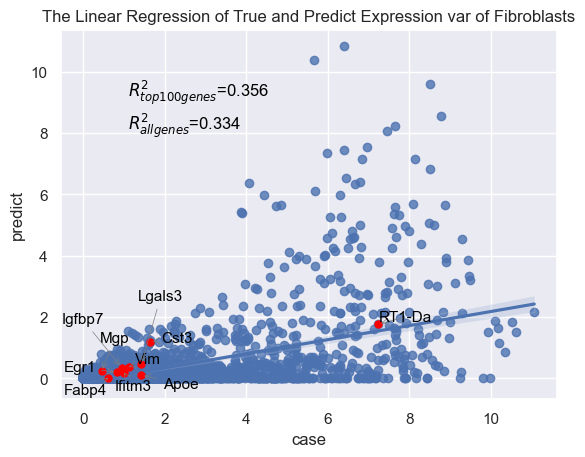

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


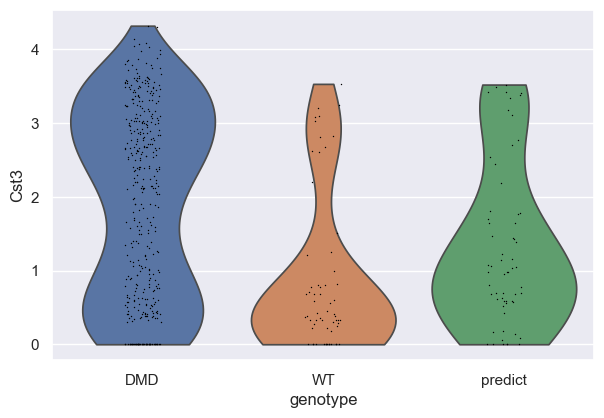

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


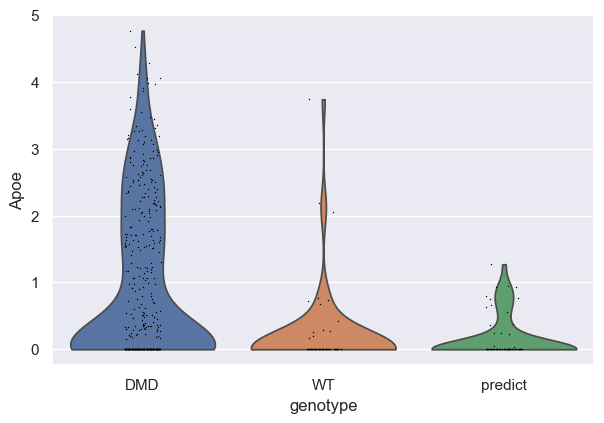

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


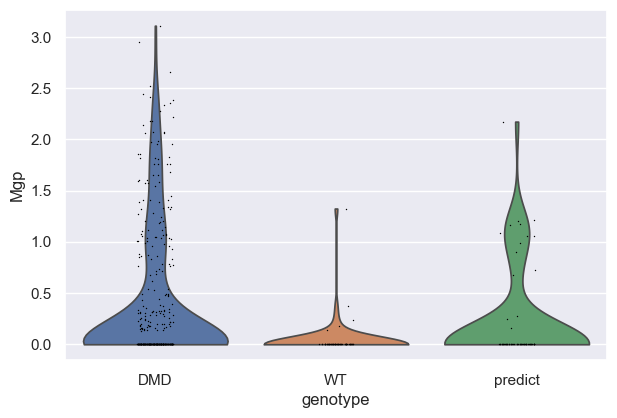

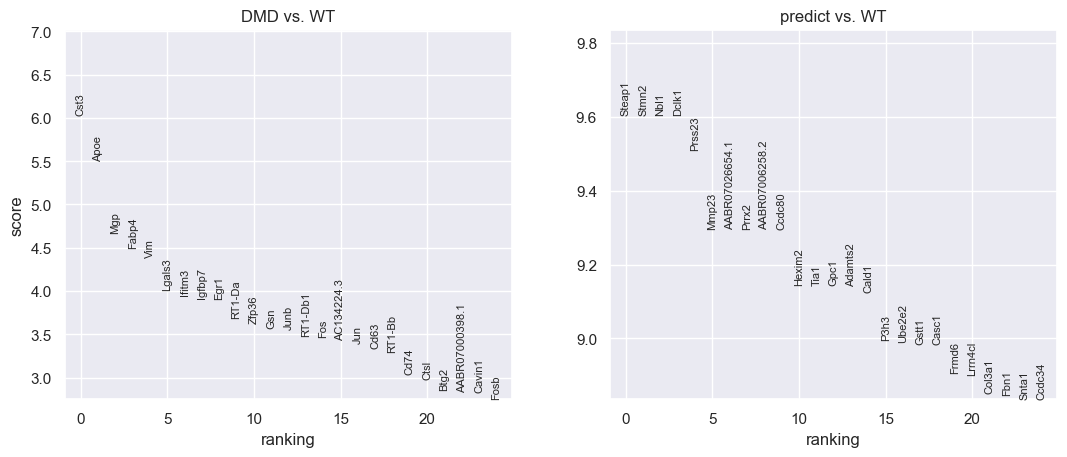

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


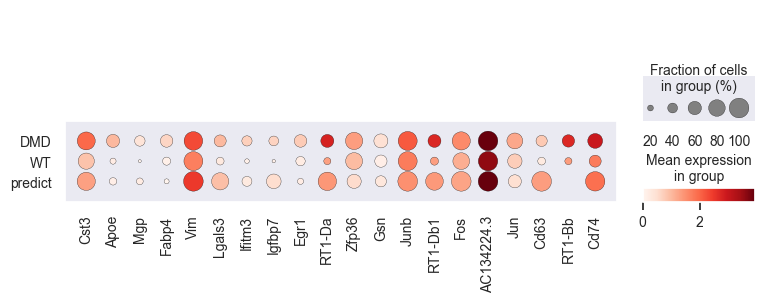


=== Processing cell type: Pericytes ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s, SCPRAM_loss=5.4e+3, kl_loss=1.04e+3, recon_loss=1.08e+4]
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabrin

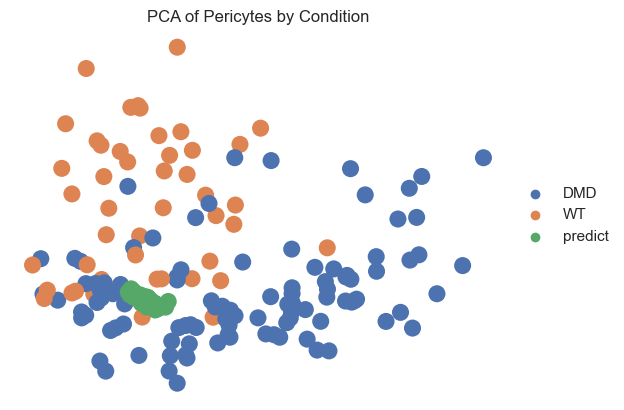

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


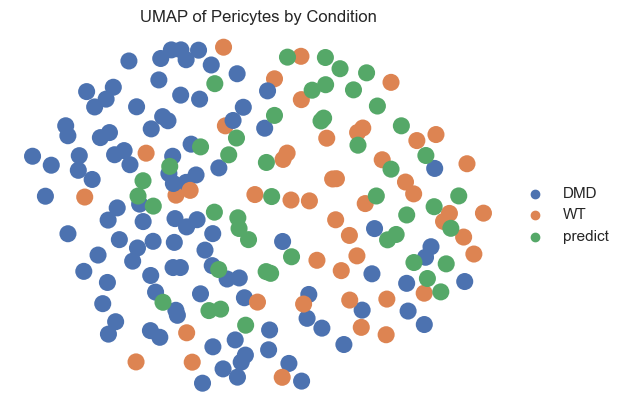

common DEGs:  3


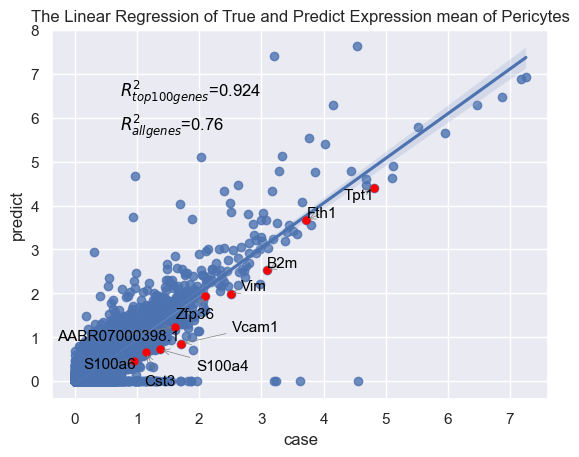

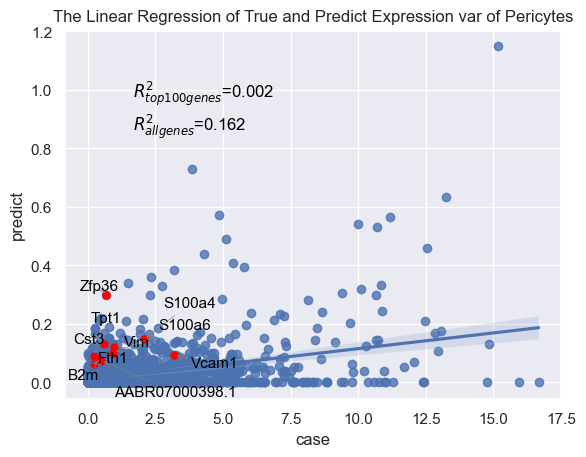

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


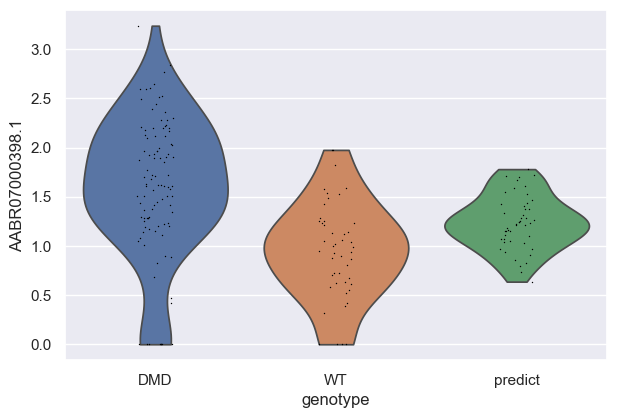

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


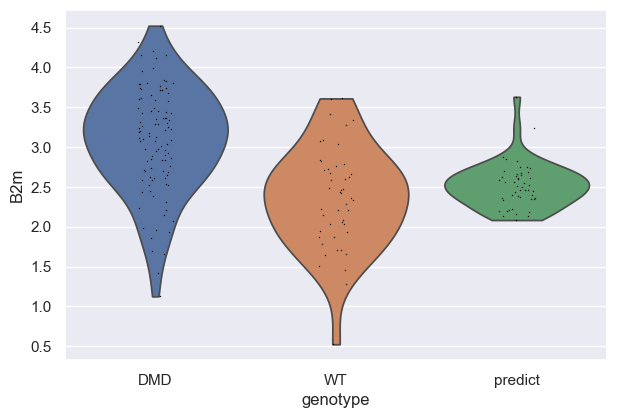

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


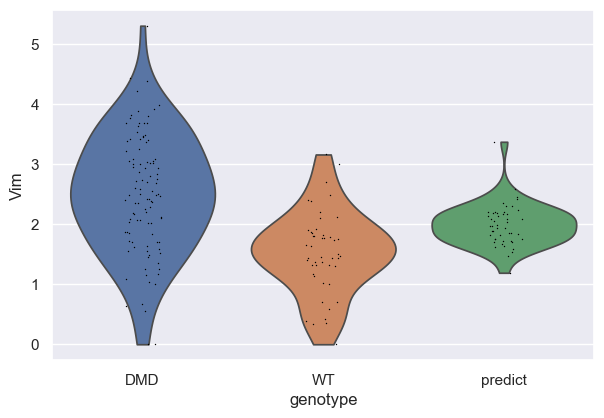

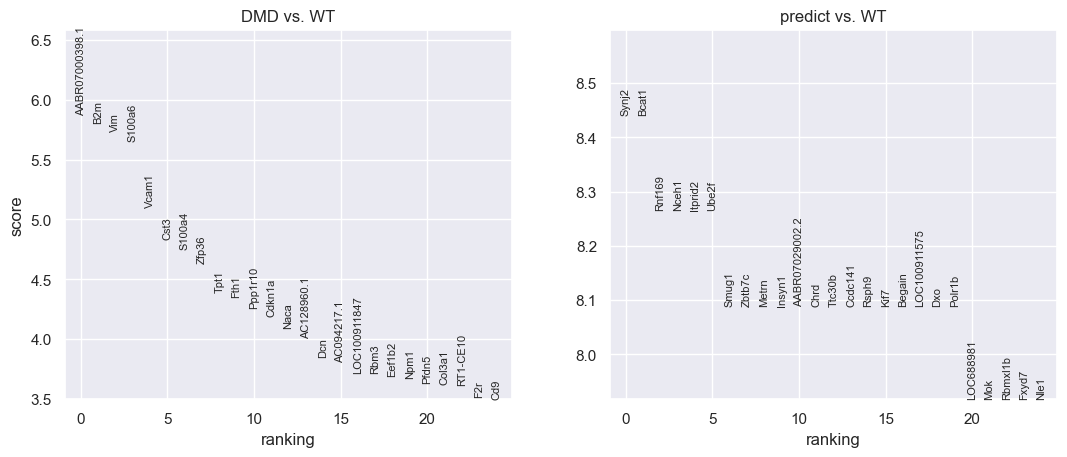

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


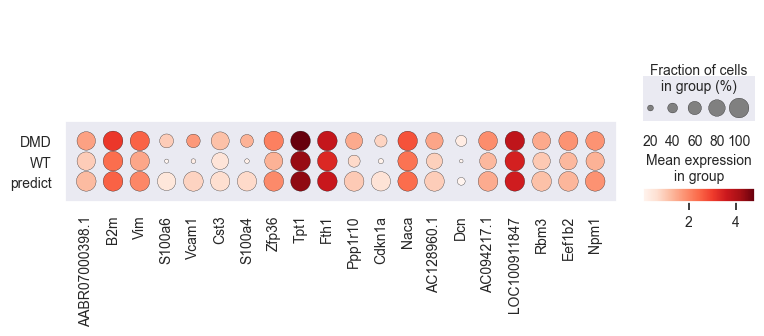


=== Processing cell type: Endoth_2 ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, SCPRAM_loss=5.02e+3, kl_loss=1.3e+3, recon_loss=1e+4]   
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabrin

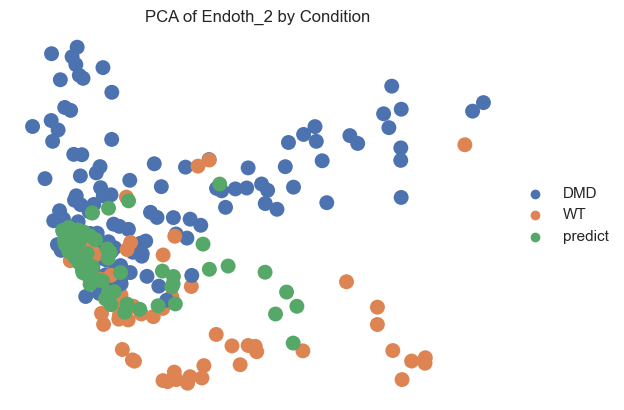

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


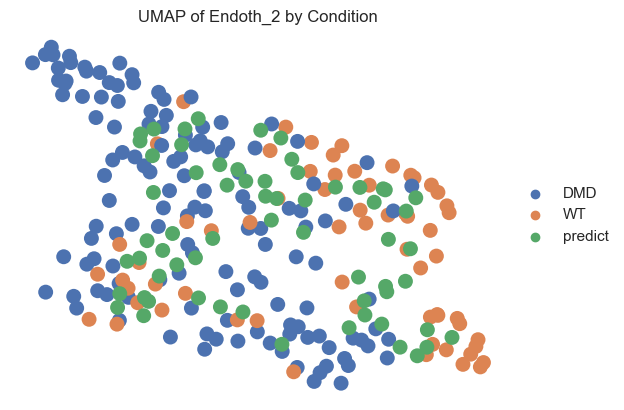

common DEGs:  3


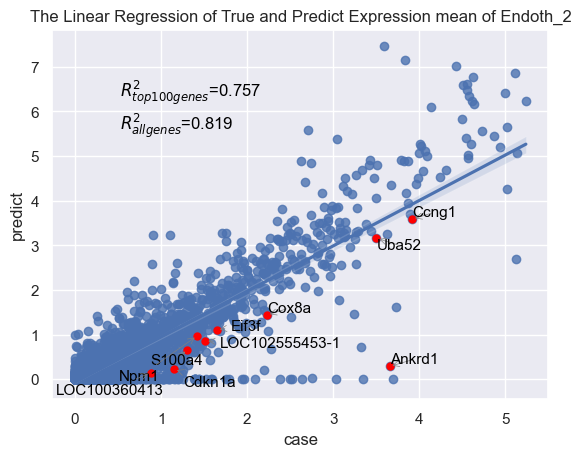

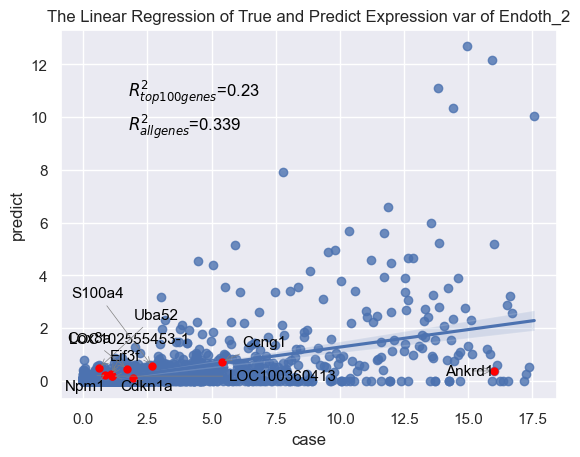

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


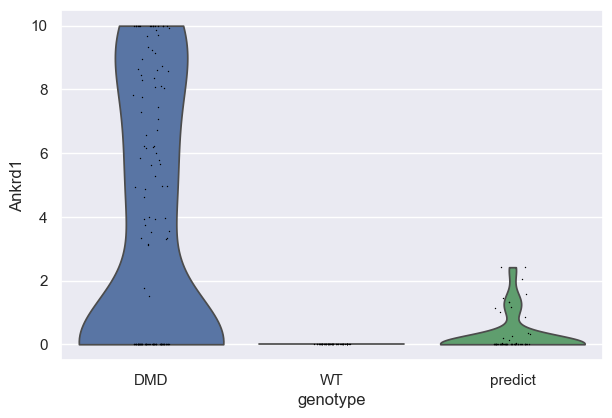

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


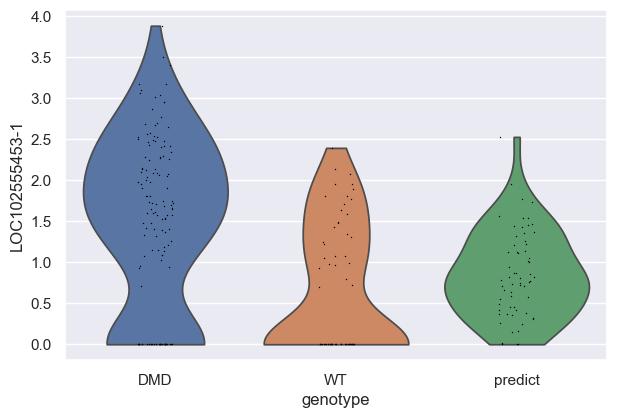

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


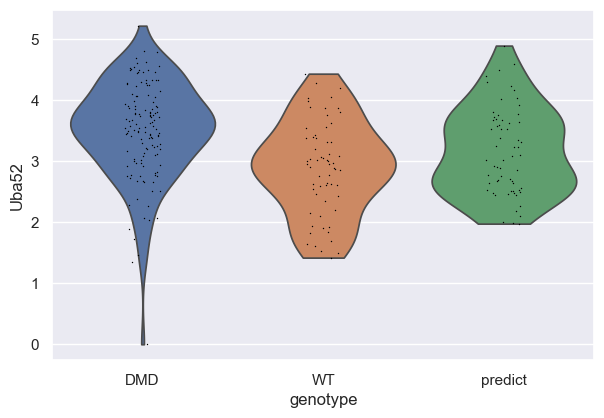

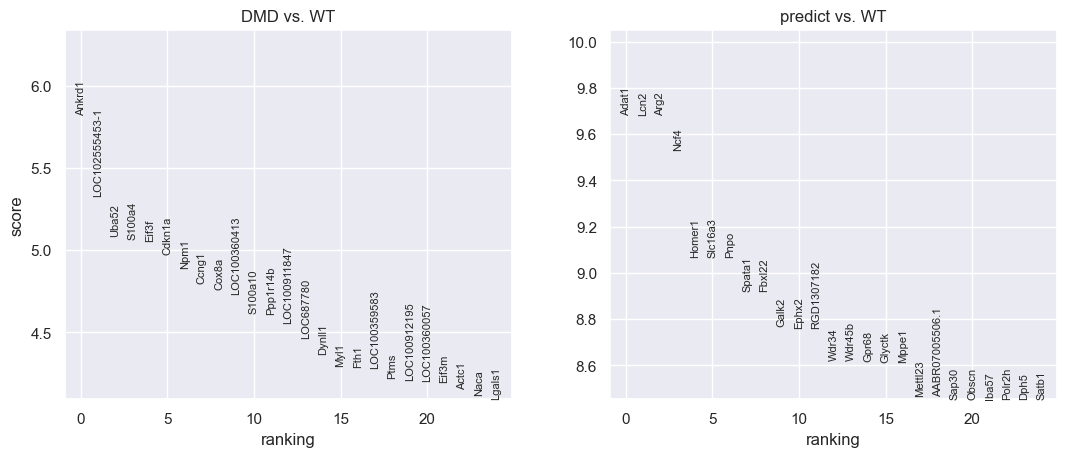

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


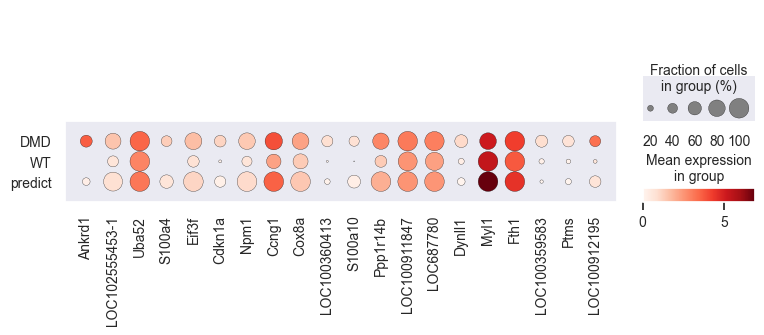


=== Processing cell type: Myonuclei ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s, SCPRAM_loss=5.18e+3, kl_loss=1.78e+3, recon_loss=1.04e+4]
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabri

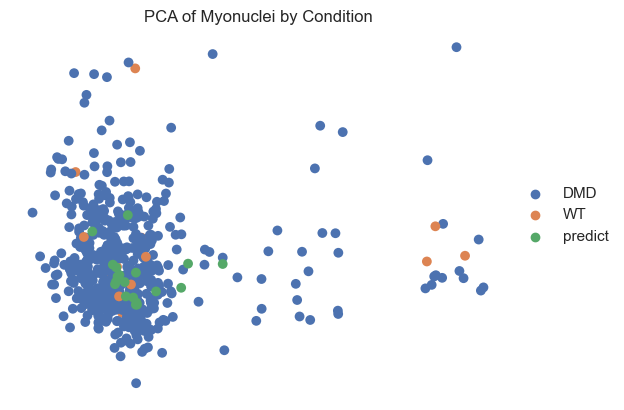

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


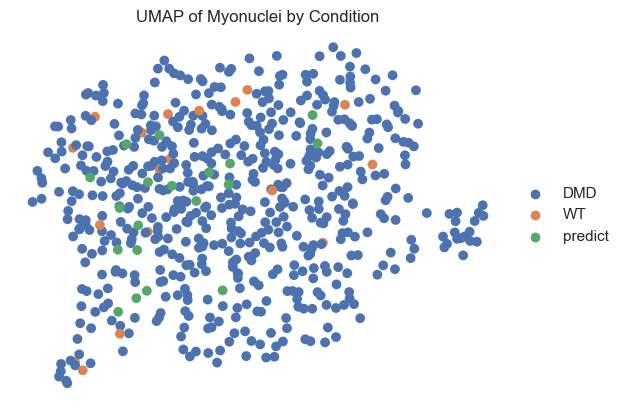

common DEGs:  0


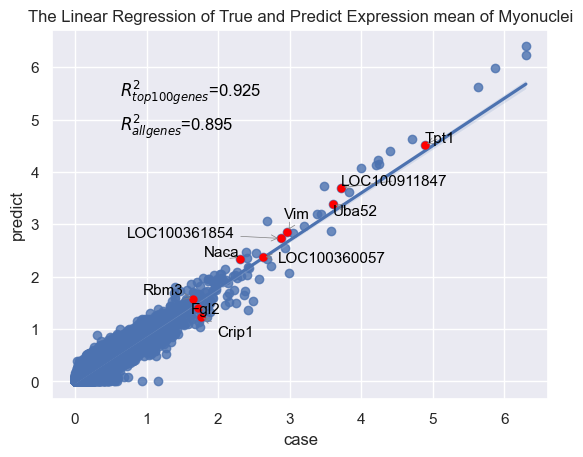

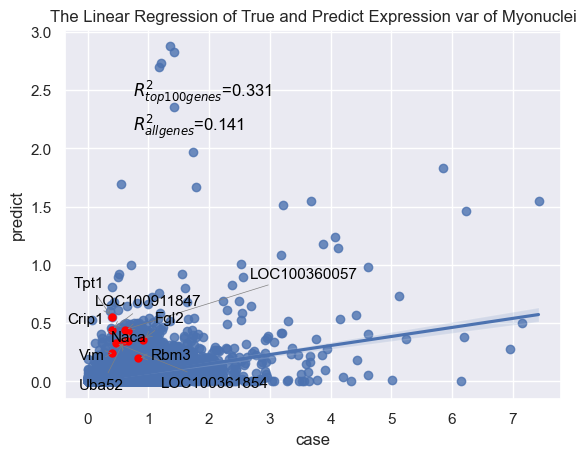

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


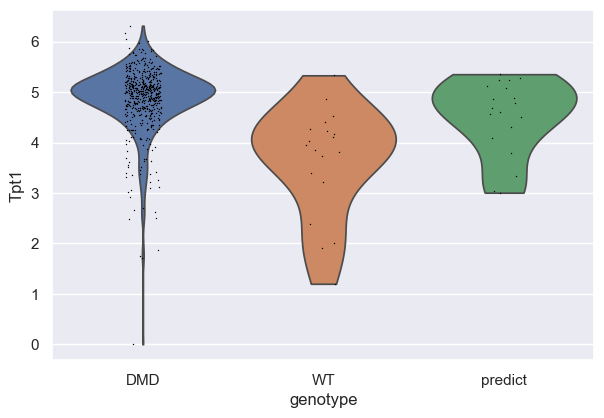

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


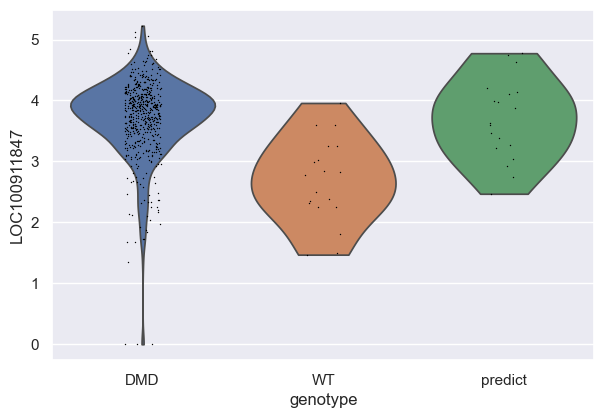

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


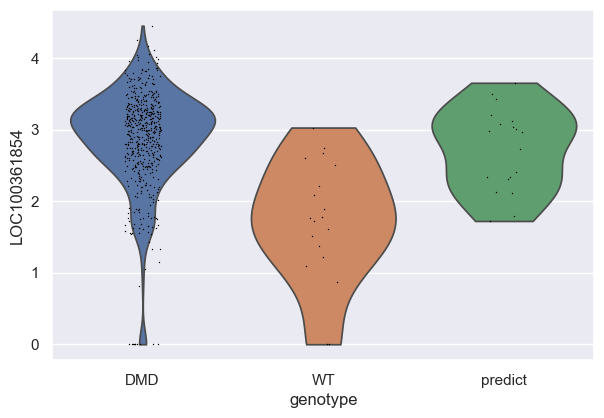

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:397: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


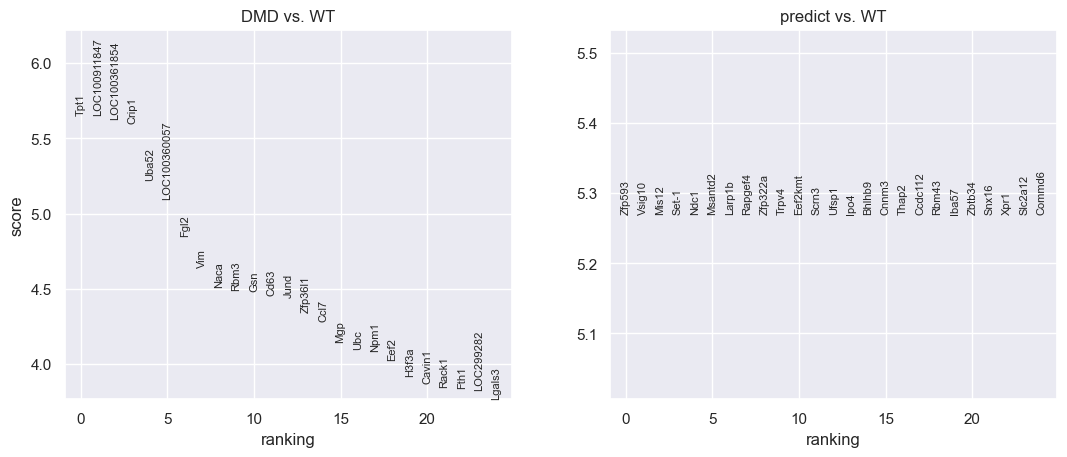

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


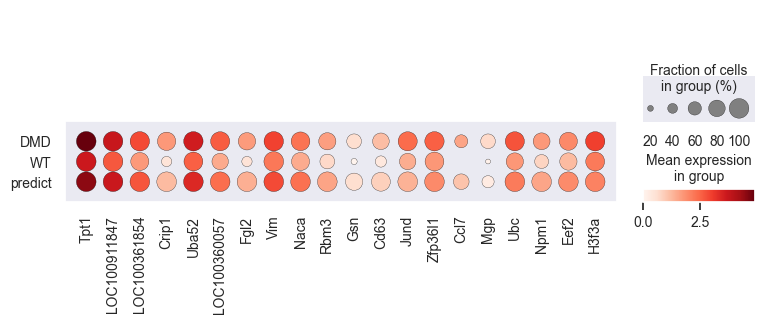


=== Processing cell type: Satellite_cells ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s, SCPRAM_loss=4.82e+3, kl_loss=2e+3, recon_loss=9.63e+3]  
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabrin

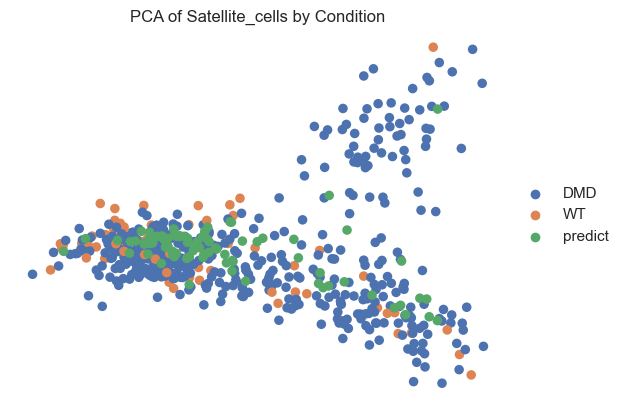

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


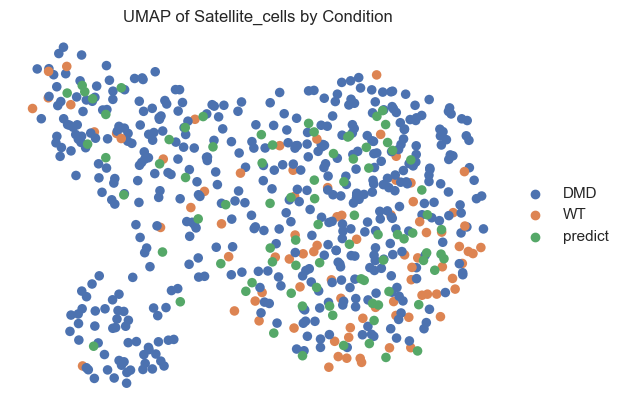

common DEGs:  0


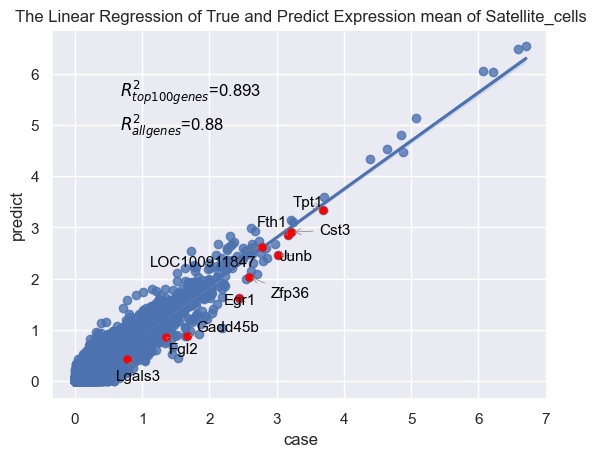

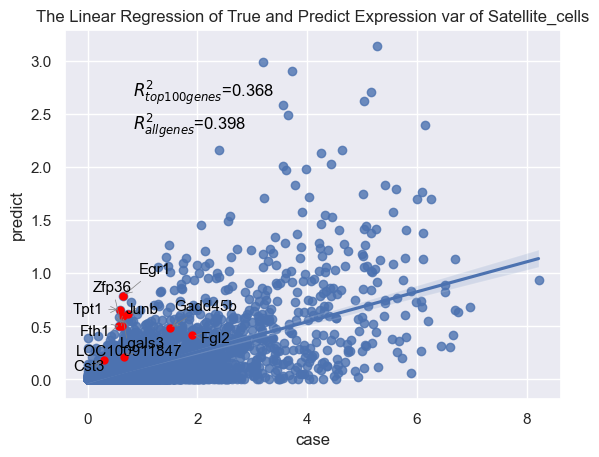

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


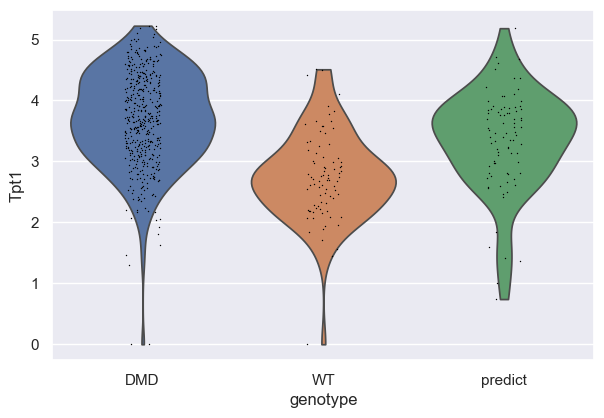

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


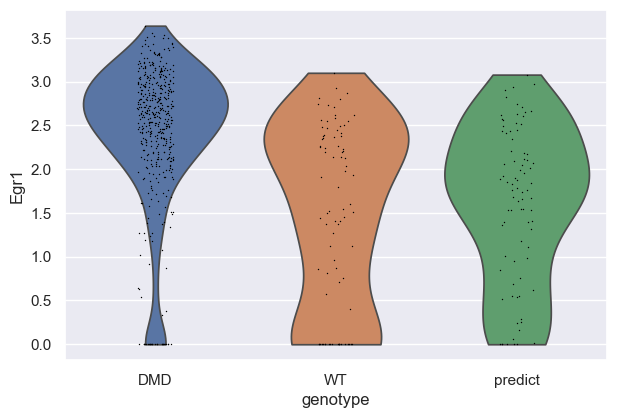

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


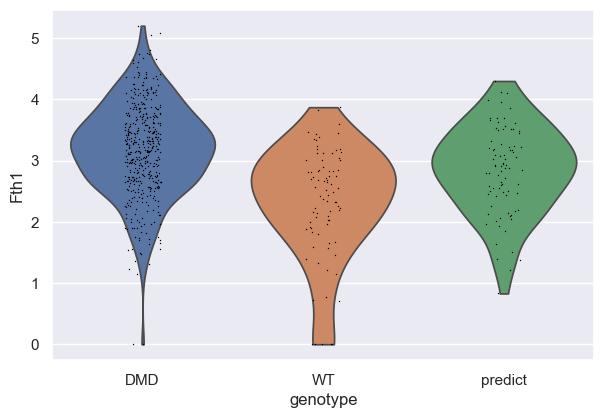

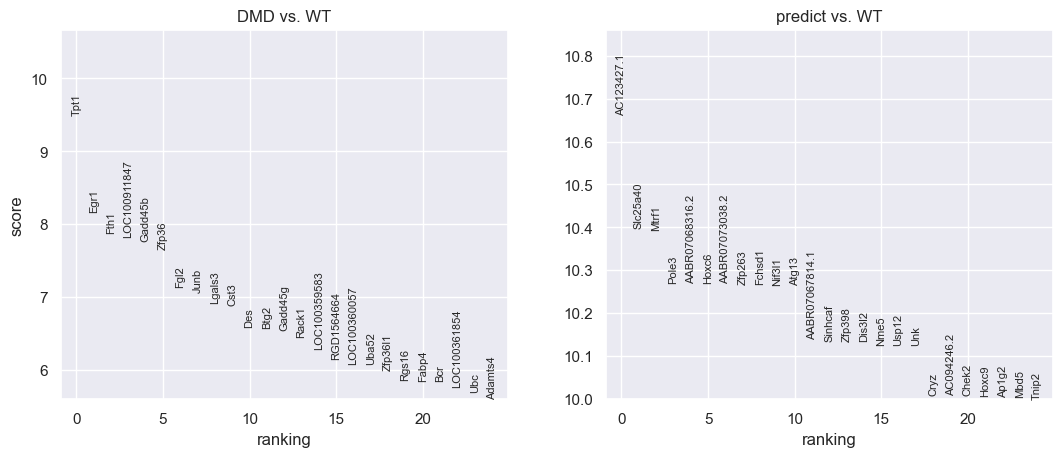

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


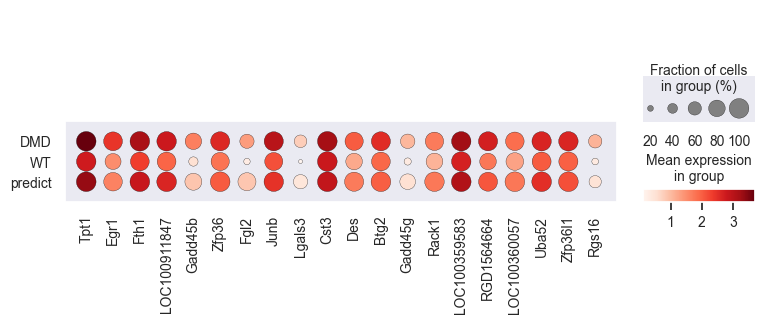


=== Processing cell type: FAP ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s, SCPRAM_loss=5e+3, kl_loss=2.76e+3, recon_loss=1e+4]     
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabrin

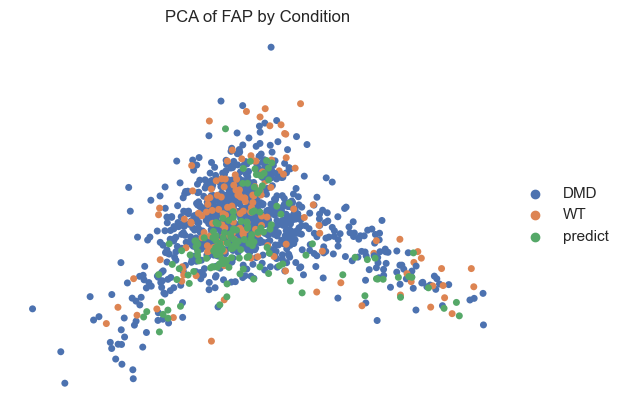

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


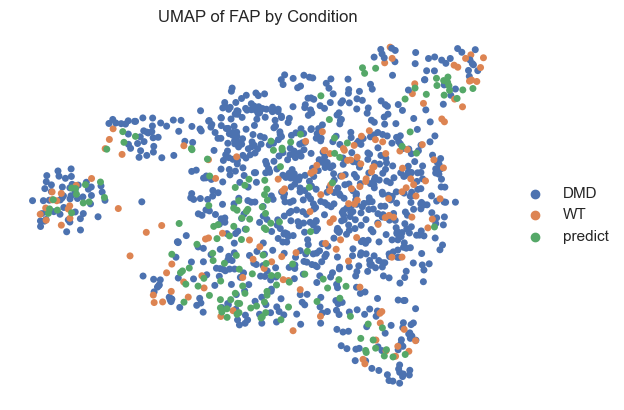

common DEGs:  1


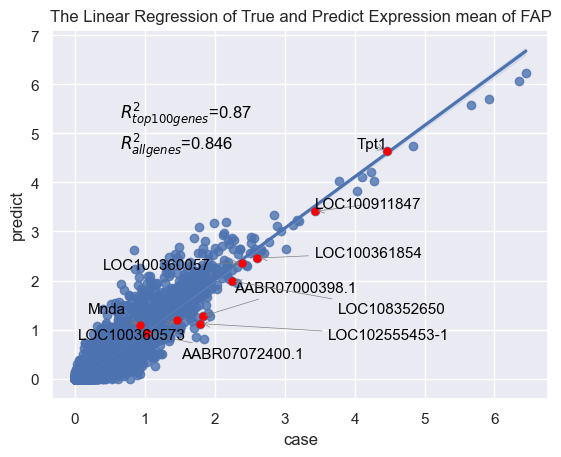

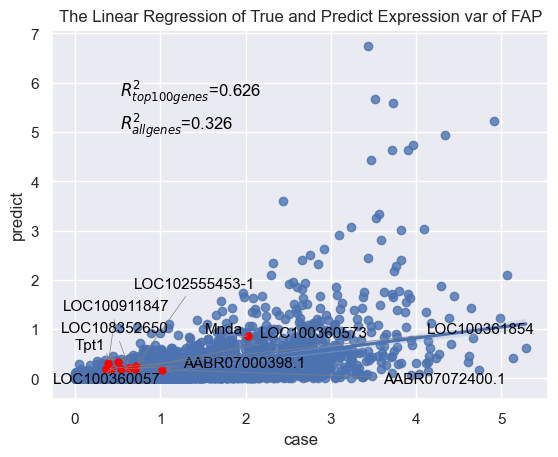

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


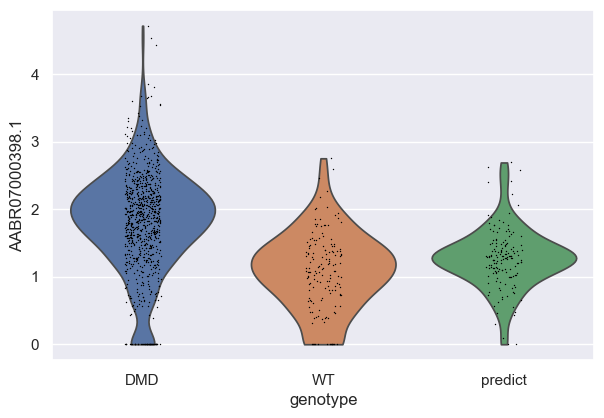

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


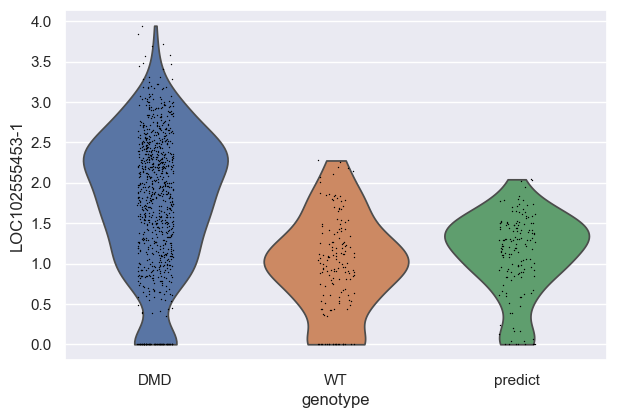

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


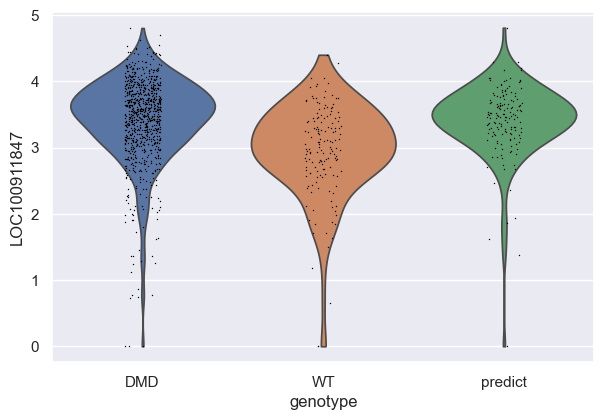

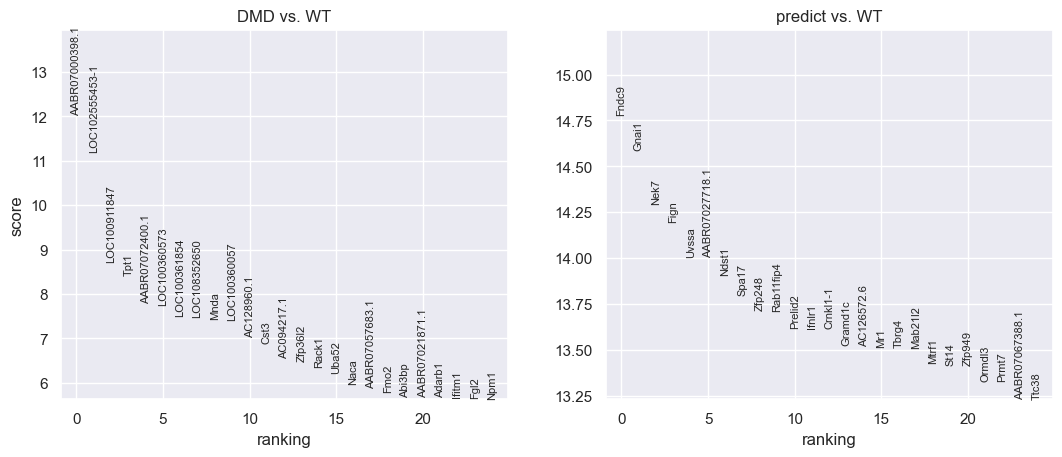

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


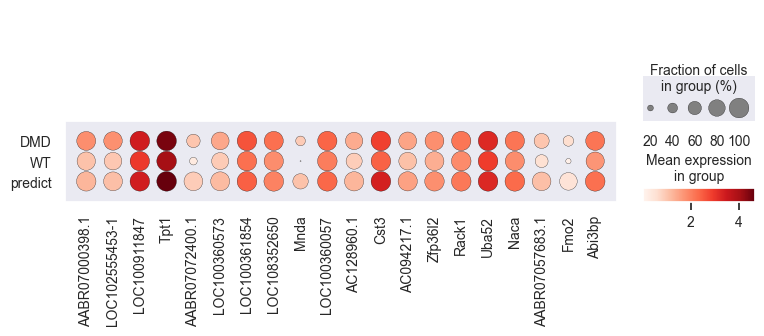


=== Processing cell type: Endoth_3 ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s, SCPRAM_loss=4.69e+3, kl_loss=3.73e+3, recon_loss=9.37e+3]
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabri

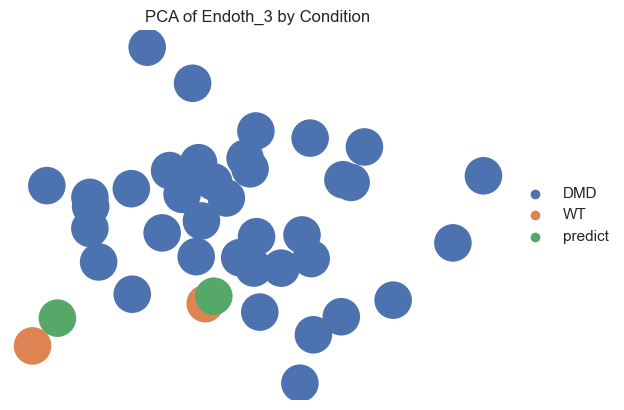

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


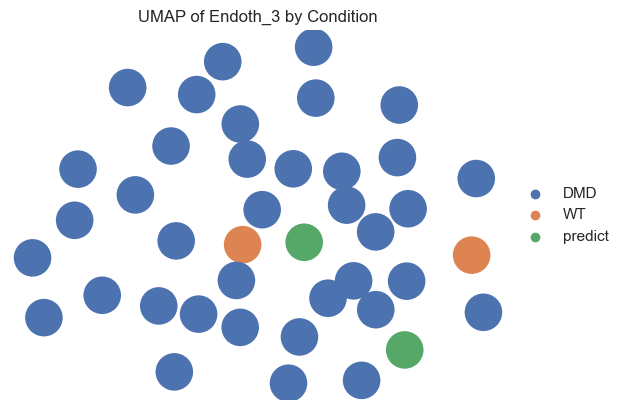

common DEGs:  20


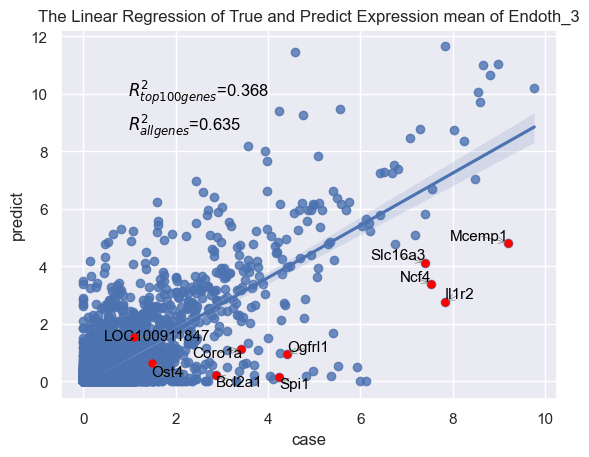

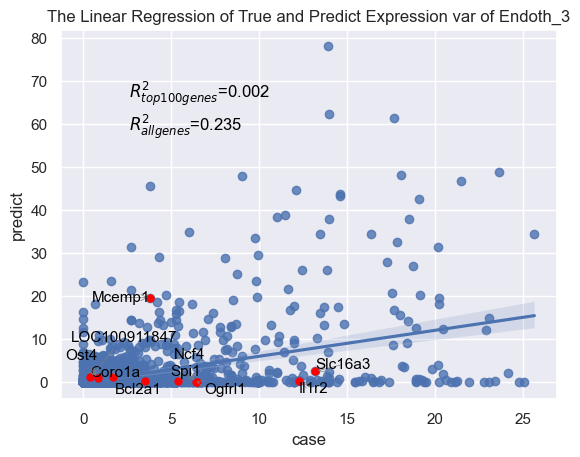

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


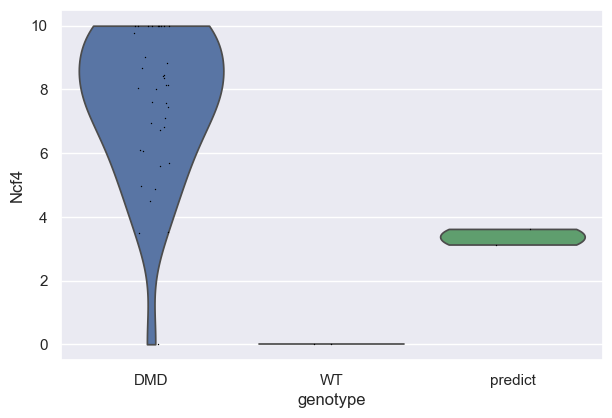

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


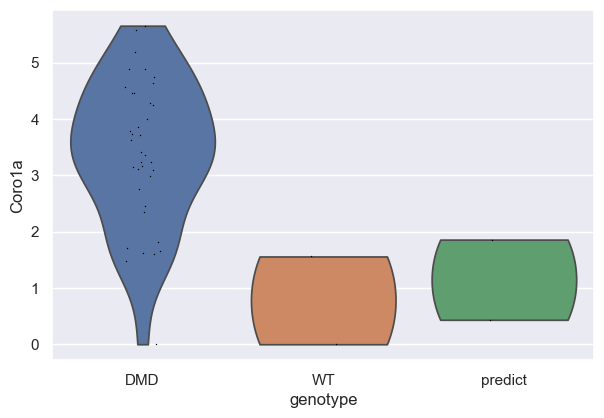

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


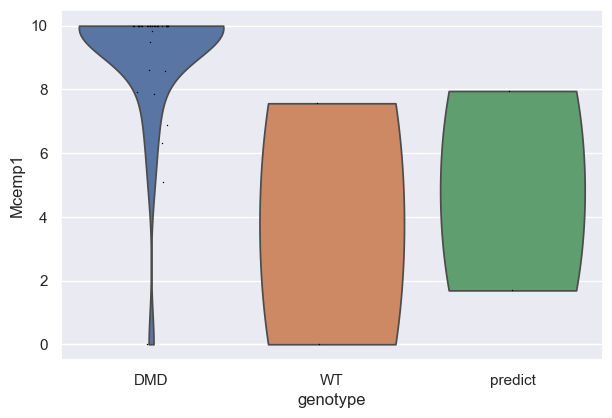

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:397: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


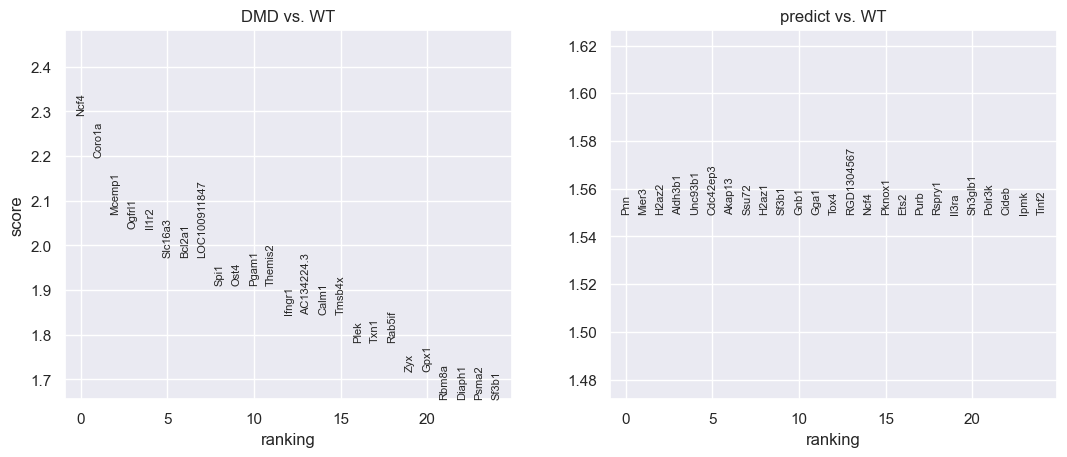

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


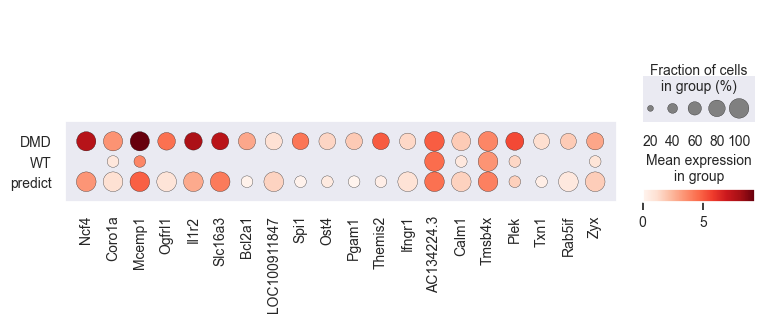


=== Processing cell type: DC-NK ===


Training Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scpram/models.py:121: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(self.parameters(), 10)
Training Epoch 9: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s, SCPRAM_loss=4.57e+3, kl_loss=4.58e+3, recon_loss=9.13e+3]
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/sabri

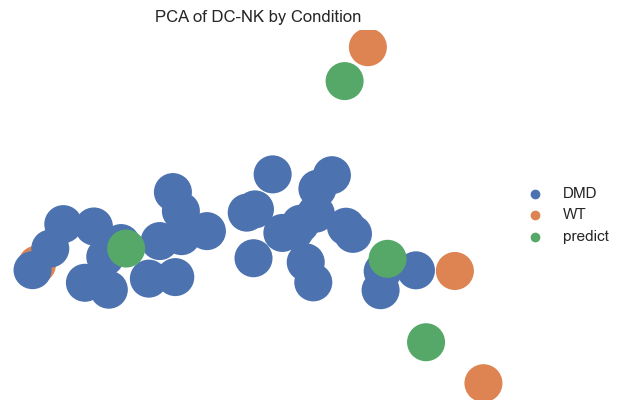

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


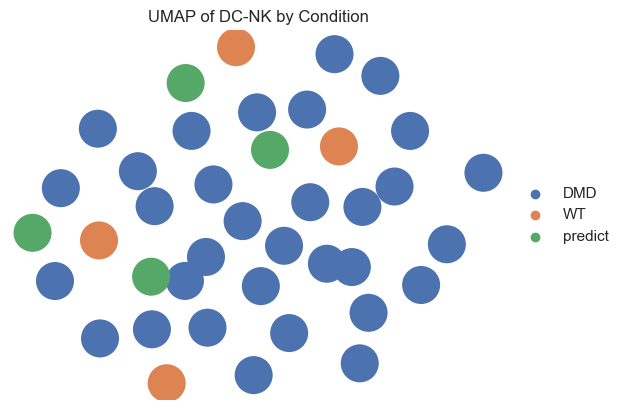

common DEGs:  5


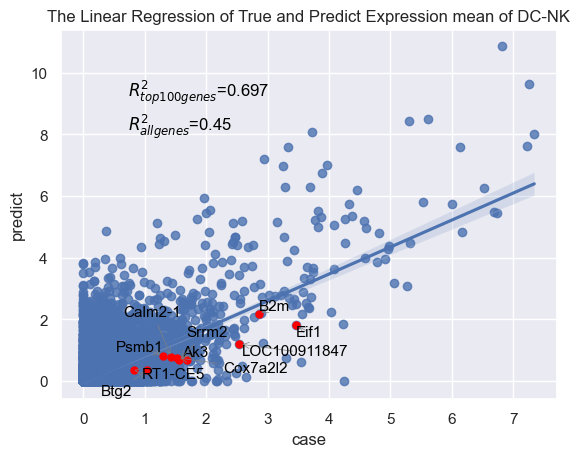

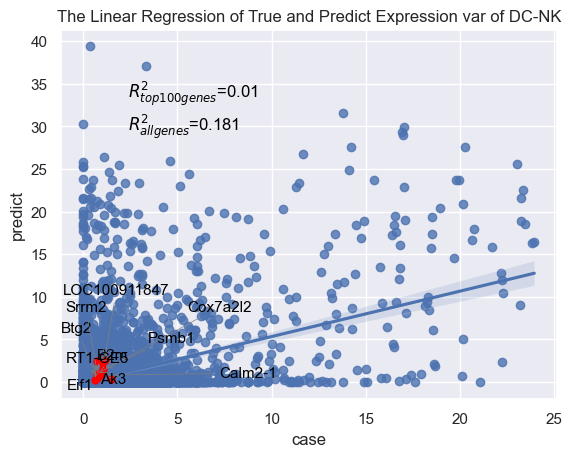

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


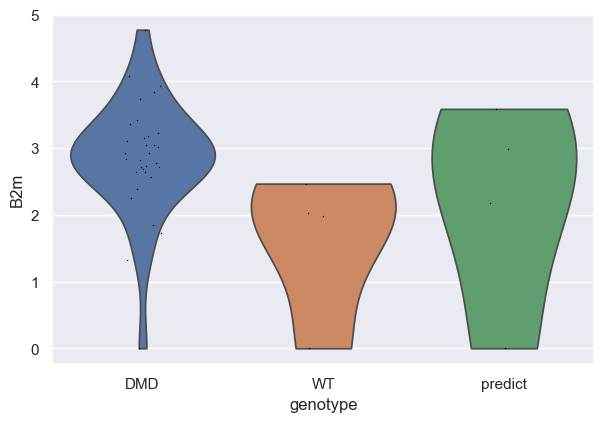

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


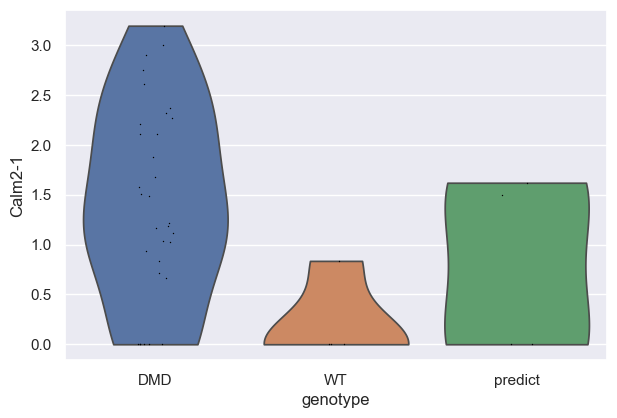

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


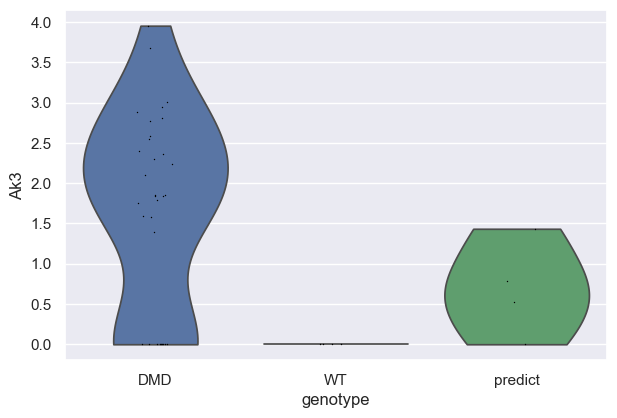

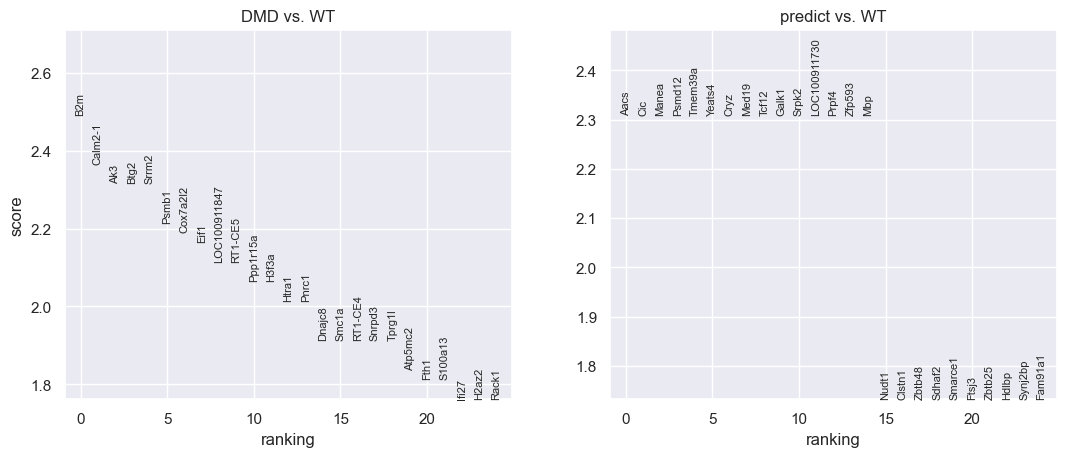

/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


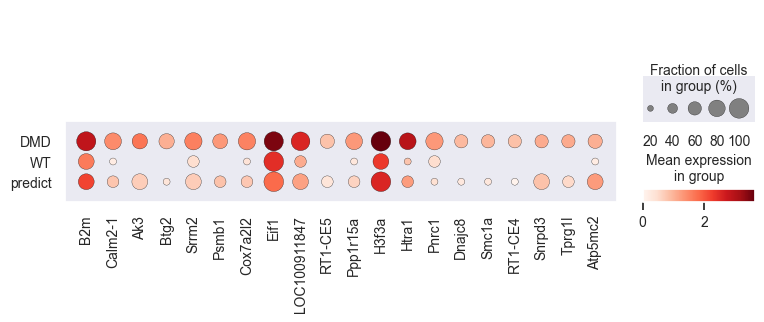

In [7]:
# Loop over each cell type and collect eval_adata objects
eval_adata_dict = {}
for cell_to_pred in cell_types:
    print(f"\n=== Processing cell type: {cell_to_pred} ===")

    try:
        # Train on all cells except those to be predicted after the perturbation
        train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
                        (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]
        model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)

        # Predict for control-condition cells of the current cell type
        adata_to_pred = adata[((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
                               (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']))]
        pred = model.predict(train_adata=train,
                             cell_to_pred=cell_to_pred,
                             key_dic=key_dic,
                             ratio=0.005)

        # Evaluate model performance and store result in dictionary
        ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)]
        eval_adata = ground_truth.concatenate(pred)
        eval_adata.obs[key_dic['condition_key']] = eval_adata.obs[key_dic['condition_key']].astype('category').cat.remove_unused_categories()

        eval_adata_dict[cell_to_pred] = eval_adata

        # Optional quick evaluation (if evaluate_adata function is defined)
        evaluate.evaluate_adata(eval_adata=eval_adata,
                                cell_type=cell_to_pred,
                                key_dic=key_dic)

    except Exception as e:
        print(f"Skipped {cell_to_pred} due to error: {e}")

### Step 6: Extended Evaluation Metrics for scPRAM

To go beyond standard R² evaluation, we perform a comprehensive set of quantitative assessments for each predicted cell type:

- **Jaccard Index** and **LFC Correlation** between top-K differentially expressed genes (DEGs) for `stim` and `pred` groups.
- **Bootstrap metrics**: R², MSE, RMSE, MAE, L2 norm, Pearson and Cosine similarity.
- **Distribution metrics**: Mean-variance KDE distance, Energy distance, and Maximum Mean Discrepancy (MMD).
- **Structure preservation**: Silhouette score and AUC from a logistic regression classifier trained on PCA coordinates.

Each metric is computed for:
- **All genes**
- The **union of top-K DEGs** across `stim` and `pred`

Summary figures are generated to compare metric distributions across cell types.

Evaluating metrics for cell type: Endoth_1
Evaluating metrics for cell type: Fibroblasts
Evaluating metrics for cell type: Pericytes
Evaluating metrics for cell type: Endoth_2
Evaluating metrics for cell type: Myonuclei
Evaluating metrics for cell type: Satellite_cells
Evaluating metrics for cell type: FAP


/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/sabrina/anaconda3/envs/scPRAM/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Evaluating metrics for cell type: Endoth_3
Evaluating metrics for cell type: DC-NK


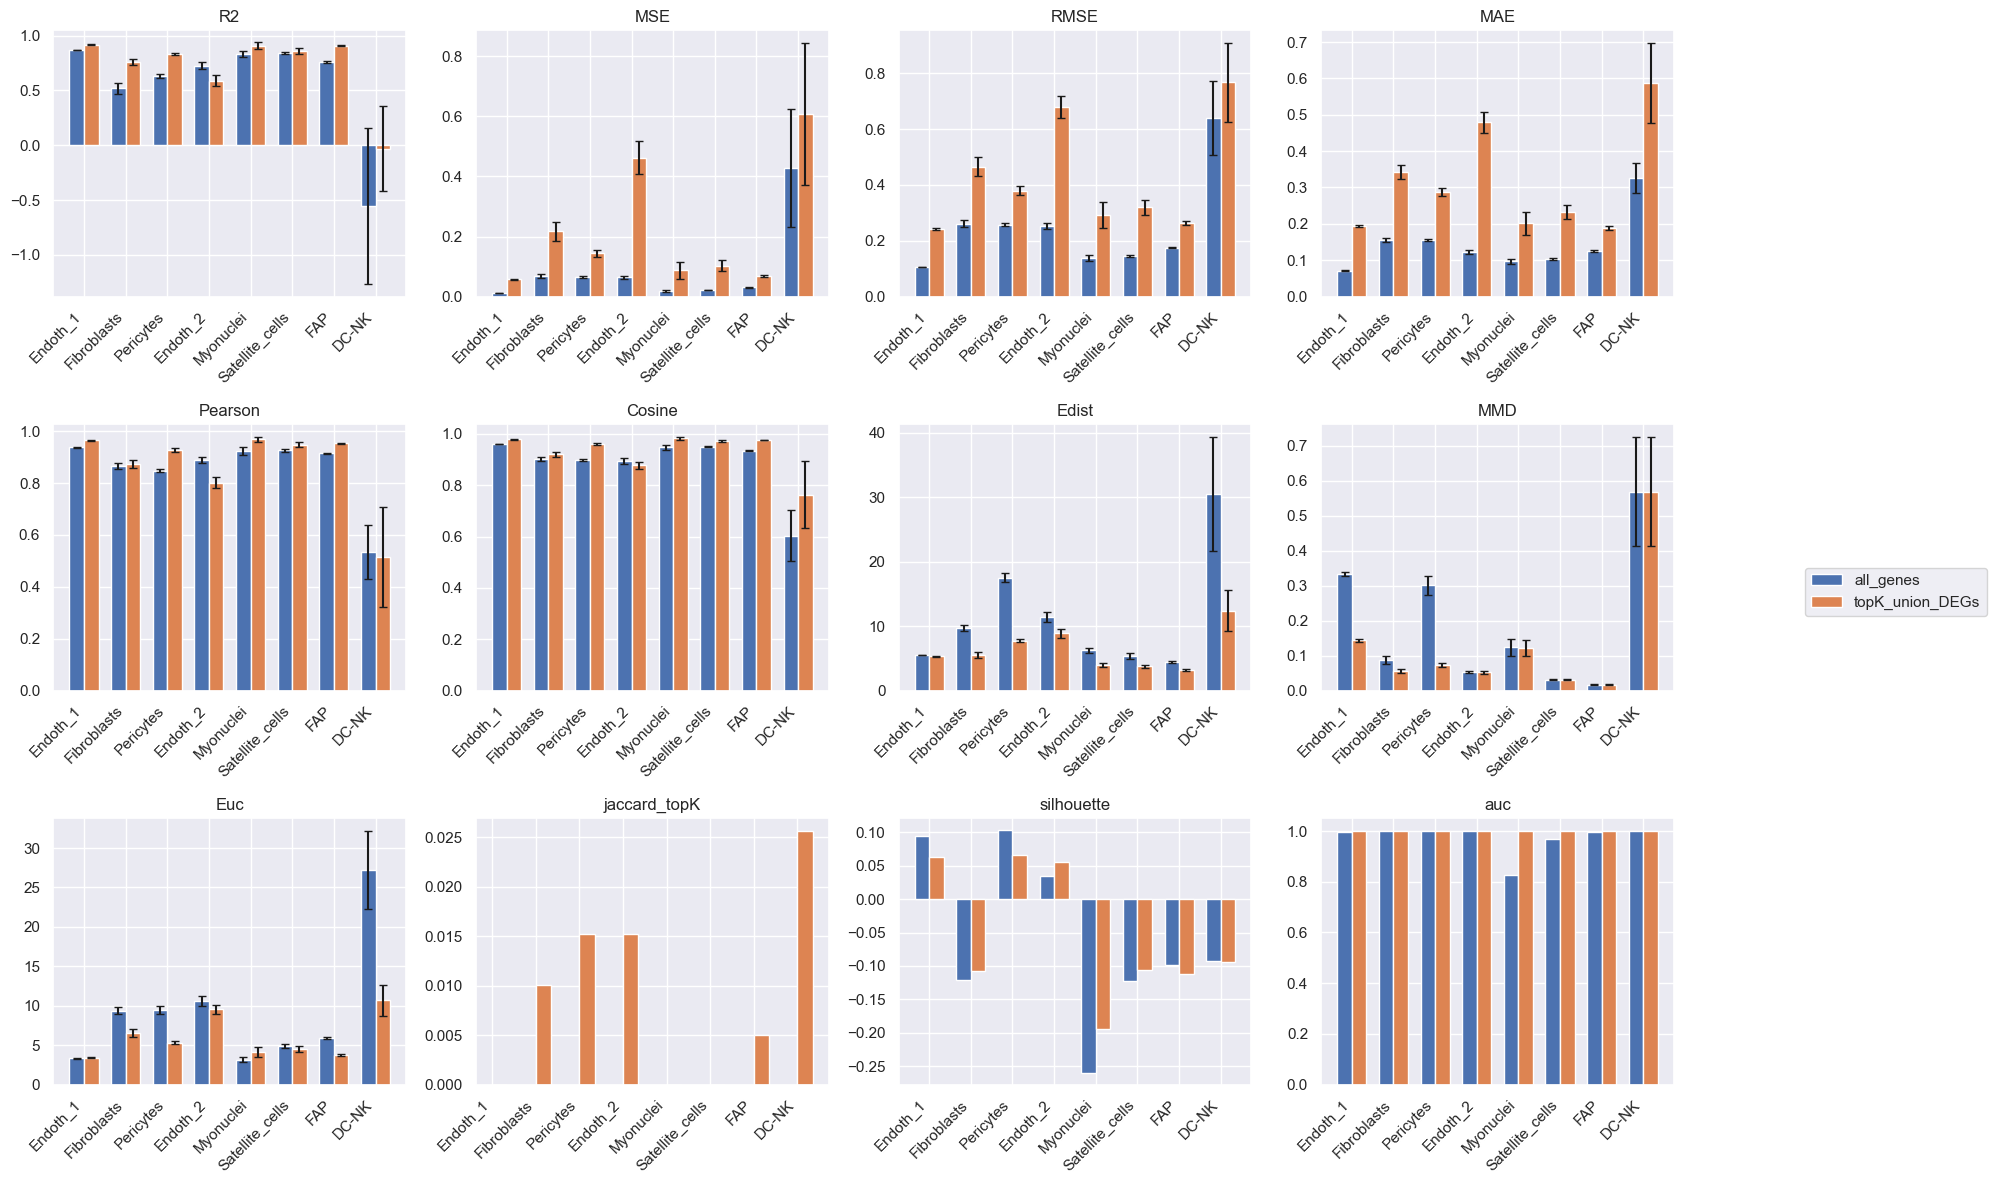

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import pairwise_distances, silhouette_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cdist, cosine as cosine_dist
from scipy import stats
from scipy import sparse

# --- Helpers ---
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1 = np.vstack([m1, v1]).T
    pts2 = np.vstack([m2, v2]).T
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.vstack(np.meshgrid(xs, ys)).reshape(2, -1).T
    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)

def bootstrap_metrics(X, mask_true, mask_pred, pca_coords, n_boot=100, frac=0.8, seed=0):
    rng = np.random.default_rng(seed)
    idx_t = np.where(mask_true)[0]
    idx_p = np.where(mask_pred)[0]
    n_t = max(1, int(frac*len(idx_t)))
    n_p = max(1, int(frac*len(idx_p)))
    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}
    for _ in range(n_boot):
        t = rng.choice(idx_t, n_t, replace=True)
        p = rng.choice(idx_p, n_p, replace=True)
        Y = X[t].mean(0); Xp = X[p].mean(0)
        d = Xp - Y
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))
        vals["Pearson"].append(stats.pearsonr(Xp, Y)[0])
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)
        Pr, Pp = pca_coords[t], pca_coords[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())
        Krr = np.exp(-cdist(Pr, Pr, 'sqeuclidean') / 2)
        Kpp = np.exp(-cdist(Pp, Pp, 'sqeuclidean') / 2)
        Krp = np.exp(-cdist(Pr, Pp, 'sqeuclidean') / 2)
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())
    out = {}
    for k in keys:
        arr = np.array(vals[k])
        out[f"{k}_mean"] = arr.mean()
        out[f"{k}_std"] = arr.std()
    return out

def compute_dist_scaled(X, m_ctrl, m_stim, m_pred, eps=1e-8):
    mc = X[m_ctrl].mean(0)
    ms = X[m_stim].mean(0)
    mp = X[m_pred].mean(0)
    ok = ~np.isnan(mc) & ~np.isnan(ms) & ~np.isnan(mp)
    d_in = np.linalg.norm(mc[ok] - ms[ok])
    d_pr = np.linalg.norm(mp[ok] - ms[ok])
    return d_pr / (d_in + eps)

# === Main Evaluation Loop ===
results = []
K = 100
cell_types = list(eval_adata_dict.keys())

for ct in cell_types:
    print(f"Evaluating metrics for cell type: {ct}")
    try:
        if ct not in eval_adata_dict:
            print(f"Skipping {ct} (no eval_adata)")
            continue
        eval_subset = eval_adata_dict[ct].copy()

        counts = eval_subset.obs['genotype'].value_counts()
        if any(counts.get(k, 0) < 3 for k in ['WT', 'DMD', 'predict']):
            continue

        sc.tl.pca(eval_subset)
        pca = eval_subset.obsm['X_pca']
        X = eval_subset.X.toarray() if sparse.issparse(eval_subset.X) else eval_subset.X
        masks = {k: eval_subset.obs['genotype'] == k for k in ['WT', 'DMD', 'predict']}

        sc.tl.rank_genes_groups(eval_subset, groupby='genotype', reference='WT',
                                groups=['DMD', 'predict'], method='wilcoxon', n_genes=eval_subset.n_vars)
        stim_genes = eval_subset.uns['rank_genes_groups']['names']['DMD'][:K].tolist()
        pred_genes = eval_subset.uns['rank_genes_groups']['names']['predict'][:K].tolist()
        shared = set(stim_genes).intersection(pred_genes)

        jaccard = len(shared) / (len(stim_genes) + len(pred_genes) - len(shared)) if shared else 0
        stim_lfc = eval_subset.uns['rank_genes_groups']['logfoldchanges']['DMD'][:K]
        pred_lfc = eval_subset.uns['rank_genes_groups']['logfoldchanges']['predict'][:K]
        lfc_corr = np.corrcoef([
            [stim_lfc[stim_genes.index(g)] for g in shared],
            [pred_lfc[pred_genes.index(g)] for g in shared]
        ])[0, 1] if shared else np.nan

        selected_genes = sorted(set(stim_genes).union(pred_genes))
        X_sel = X[:, [eval_subset.var_names.get_loc(g) for g in selected_genes]]
        PCA_sel = PCA().fit_transform(X_sel)

        for label, xmat, pca_coords in [('all_genes', X, pca), ('topK_union_DEGs', X_sel, PCA_sel)]:
            boot = bootstrap_metrics(xmat, masks['DMD'], masks['predict'], pca_coords)
            dist_scaled = compute_dist_scaled(xmat, masks['WT'], masks['DMD'], masks['predict'])
            kde = mean_var_kde_distance(xmat[masks['DMD']], xmat[masks['predict']])
            combined = masks['DMD'] | masks['predict']
            lbls = eval_subset.obs['genotype'][combined].map({'DMD':1,'predict':0}).values
            emb = pca_coords[combined]
            sil = silhouette_score(emb, lbls)
            clf = LogisticRegression(max_iter=1000).fit(emb, lbls)
            auc = roc_auc_score(lbls, clf.predict_proba(emb)[:, 1])
            j_val = jaccard if label == 'topK_union_DEGs' else np.nan
            c_val = lfc_corr if label == 'topK_union_DEGs' else np.nan

            results.append({
                'cell_type': ct,
                'gene_set': label,
                'jaccard_topK': j_val,
                'lfc_corr': c_val,
                'dist_scaled': dist_scaled,
                'mean_var_distn': kde,
                'silhouette': sil,
                'auc': auc,
                **boot
            })
    except Exception as e:
        print(f"Error on {ct}: {e}")

# Plot
res_df = pd.DataFrame(results)
if not res_df.empty:
    metrics = [
        ("R2_mean","R2_std"),("MSE_mean","MSE_std"),("RMSE_mean","RMSE_std"),("MAE_mean","MAE_std"),
        ("Pearson_mean","Pearson_std"),("Cosine_mean","Cosine_std"),("Edist_mean","Edist_std"),
        ("MMD_mean","MMD_std"),("Euc_mean","Euc_std"),("jaccard_topK",None),("silhouette",None),("auc",None)
    ]
    cell_types = res_df['cell_type'].unique()
    gene_sets = res_df['gene_set'].unique()
    bar_width = 0.35
    x = np.arange(len(cell_types))
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
    axes = axes.ravel()

    for ax, (mean_col, std_col) in zip(axes, metrics):
        for i, gs in enumerate(gene_sets):
            sub = res_df[res_df['gene_set'] == gs]
            y = sub.groupby('cell_type')[mean_col].first().reindex(cell_types)
            yerr = sub.groupby('cell_type')[std_col].first().reindex(cell_types) if std_col else None
            offset = (i - len(gene_sets)/2) * bar_width + bar_width/2
            ax.bar(x + offset, y.values, bar_width,
                   yerr=(yerr.values if yerr is not None else None),
                   capsize=3, label=gs)
        ax.set_xticks(x)
        ax.set_xticklabels(cell_types, rotation=45, ha='right')
        ax.set_title(mean_col.replace('_mean',''))
    for ax in axes[len(metrics):]: ax.axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
else:
    print("No evaluation results to display.")
